<a href="https://colab.research.google.com/github/RandyV37/Telecom-X-part-2-Data-Science-/blob/main/TelecomX(Challenge_parte_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Carga de datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import NearMiss
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold



df = pd.read_csv('TelecomX_Data_Tratada.csv')


## Ubicar Variables categoricas

In [ ]:
Variables_Categoricas = df.select_dtypes(include=['object']).columns.tolist()

## Conversion

In [ ]:
encoder = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore'
)

Array_codificado = encoder.fit_transform(df[Variables_Categoricas])
Variables_categoricas_codificadas = encoder.get_feature_names_out(Variables_Categoricas)
df_x_codificada = pd.DataFrame(Array_codificado, columns=Variables_categoricas_codificadas, index=df.index)
variables_numericas = df.drop(columns=Variables_Categoricas)
Df_final = pd.concat([variables_numericas, df_x_codificada], axis=1)

## Dividir base de datos entre entrenamiento y prueba

In [ ]:
X = Df_final.drop(columns=['Cliente_Detractor'])
y = Df_final['Cliente_Detractor']


kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in kf.split(X):
    print(f"\n--- Fold {fold} ---")


    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    print(f"Training size: {X_train_fold.shape[0]}, Test size: {X_test_fold.shape[0]}")
    fold += 1


--- Fold 1 ---
Training size: 5813, Test size: 1454

--- Fold 2 ---
Training size: 5813, Test size: 1454

--- Fold 3 ---
Training size: 5814, Test size: 1453

--- Fold 4 ---
Training size: 5814, Test size: 1453

--- Fold 5 ---
Training size: 5814, Test size: 1453


## Balanceo de clases

### Muestreo


In [ ]:

train_combined = pd.concat([X_train_fold, y_train_fold], axis=1)


train_majority = train_combined[train_combined.Cliente_Detractor == 0]
train_minority = train_combined[train_combined.Cliente_Detractor == 1]


train_majority_downsampled = resample(
    train_majority,
    replace=False,
    n_samples=len(train_minority),
    random_state=42
)

train_balanced = pd.concat([train_majority_downsampled, train_minority])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = train_balanced.drop(columns=['Cliente_Detractor'])
y_train_bal = train_balanced['Cliente_Detractor']

In [ ]:
print("Before Undersample:", Counter(y_train_fold))
print("After Undersample:", Counter(y_train_bal))

Before Undersample: Counter({0: 4312, 1: 1502})
After Undersample: Counter({0: 1502, 1: 1502})


### Muestreo

In [ ]:

smote = SMOTE(random_state=42)

X_train_Oversample, y_train_Oversample = smote.fit_resample(X_train_fold, y_train_fold)

In [ ]:
print("Before SMOTE:", Counter(y_train_fold))
print("After SMOTE:", Counter(y_train_fold))

Before SMOTE: Counter({0: 4312, 1: 1502})
After SMOTE: Counter({0: 4312, 1: 1502})


## Modelo de Regresión

In [ ]:

nm = NearMiss(version=3)
X_train_nm, y_train_nm = nm.fit_resample(X_train_fold, y_train_fold)

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_nm, y_train_nm)
y_pred = knn_model.predict(X_test_fold)

### Scorings

In [ ]:

accuracy = accuracy_score(y_test_fold, y_pred)
print(f'Accuracy: {accuracy:.4f}')


print("Classification Report:")
print(classification_report(y_test_fold, y_pred))


print("Confusion Matrix:")
print(confusion_matrix(y_test_fold, y_pred))

Accuracy: 0.7034
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1086
           1       0.44      0.59      0.50       367

    accuracy                           0.70      1453
   macro avg       0.64      0.67      0.65      1453
weighted avg       0.74      0.70      0.72      1453

Confusion Matrix:
[[804 282]
 [149 218]]


### Creación de Pipeline para refinar resultados

In [ ]:
knn_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline.fit(X_train_nm, y_train_nm)
y_pred = knn_pipeline.predict(X_test_fold)

print(f'Accuracy: {accuracy_score(y_test_fold, y_pred):.4f}')
print(classification_report(y_test_fold, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_fold, y_pred))

Accuracy: 0.7268
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1086
           1       0.47      0.65      0.55       367

    accuracy                           0.73      1453
   macro avg       0.67      0.70      0.68      1453
weighted avg       0.77      0.73      0.74      1453

Confusion Matrix:
[[817 269]
 [128 239]]


### Curva ROC y AUC para evaluación del modelo.

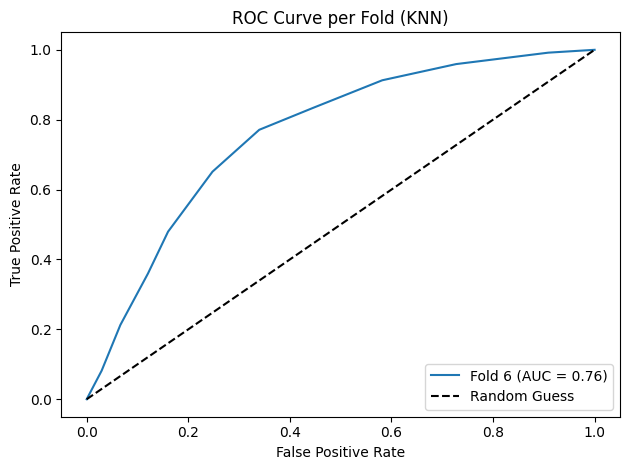

In [ ]:
auc_scores = []
y_proba = knn_pipeline.predict_proba(X_test_fold)[:, 1]


auc = roc_auc_score(y_test_fold, y_proba)

fpr, tpr, _ = roc_curve(y_test_fold, y_proba)


plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Fold (KNN)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Modelo de arbol de decisión

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
rf_model.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_model.predict(X_test_fold)

### Scoring

In [ ]:

print(f'Accuracy: {accuracy_score(y_test_fold, y_pred_rf):.4f}')


print("Classification Report:")
print(classification_report(y_test_fold, y_pred_rf))


print("Confusion Matrix:")
print(confusion_matrix(y_test_fold, y_pred_rf))

Accuracy: 0.7515
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1086
           1       0.50      0.83      0.63       367

    accuracy                           0.75      1453
   macro avg       0.72      0.78      0.72      1453
weighted avg       0.82      0.75      0.77      1453

Confusion Matrix:
[[787 299]
 [ 62 305]]


### Visualización de Matriz de Confusión

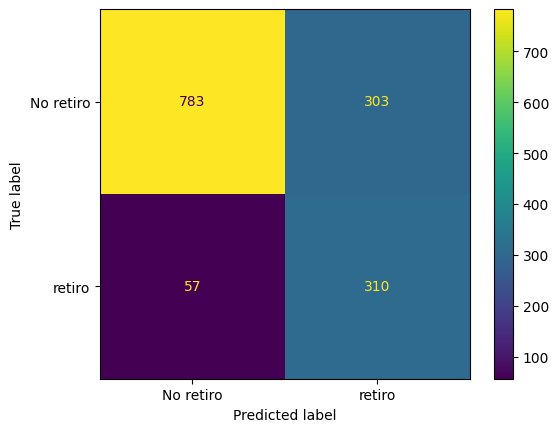

In [ ]:
matriz_confusion = confusion_matrix(y_test_fold, y_pred_rf)
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion, display_labels=['No retiro', 'retiro'])
visualizacion.plot();

### Determinar la importancia de las Features para afinar el modelo.

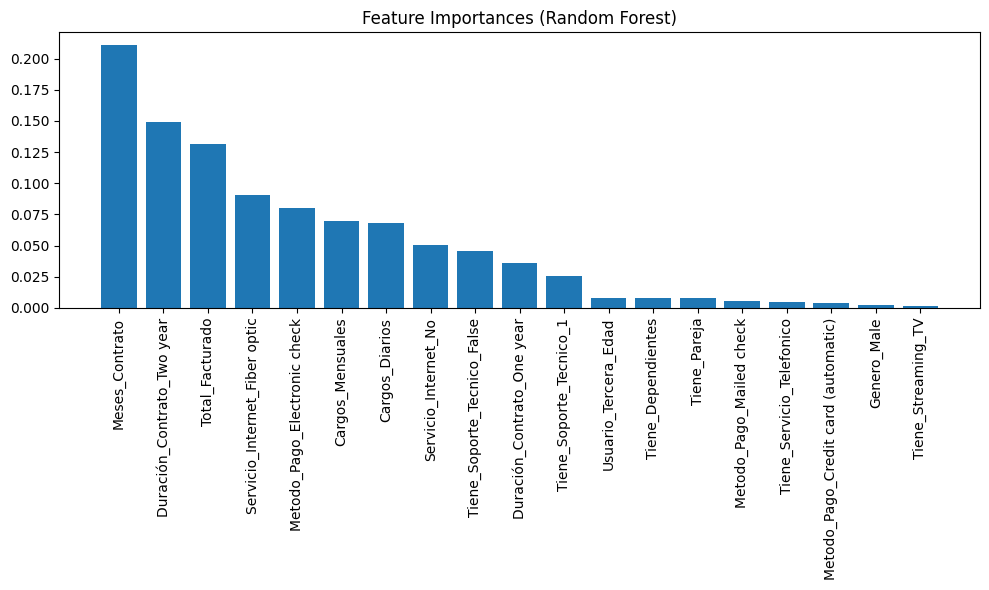

In [ ]:

importances = rf_model.feature_importances_
feature_names = X_train_fold.columns


indices = np.argsort(importances)[::-1]


plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

### Iteración para determinar y entrenar al modelo con la cantidad necesaria de Features.

In [ ]:
ct_features = [i if i != 0 else 1 for i in range(0,35,5)]
resultados = pd.DataFrame(index=['Features', 'Precision', 'Recall', 'F1-Score', 'Support'])
rf_model_features = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
for i in ct_features:


  selected_feature_names = feature_names[indices[:i]]

  x_train_sel = X_train_bal[selected_feature_names]
  X_test_sel = X_test_fold[selected_feature_names]

  rf_model_features.fit(x_train_sel, y_train_bal)
  y_pred_rf = rf_model_features.predict(X_test_sel)
  report_dict = classification_report(y_test_fold, y_pred_rf, output_dict=True)

  precision = report_dict['1']['precision']
  recall = report_dict['1']['recall']
  f1_score = report_dict['1']['f1-score']
  support = report_dict['1']['support']


  resultados[i] = [', '.join(selected_feature_names), precision, recall, f1_score, support]

resultados

,1,5,10,15,20,25,30
Features,Meses_Contrato,"Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To...","Meses_Contrato, Duración_Contrato_Two year, To..."
Precision,0.427101,0.5053,0.519199,0.515913,0.504967,0.504967,0.504967
Recall,0.678474,0.779292,0.847411,0.839237,0.831063,0.831063,0.831063
F1-Score,0.524211,0.613076,0.643892,0.639004,0.628218,0.628218,0.628218
Support,367.0,367.0,367.0,367.0,367.0,367.0,367.0


### Curva ROC y AUC score para Random Forest

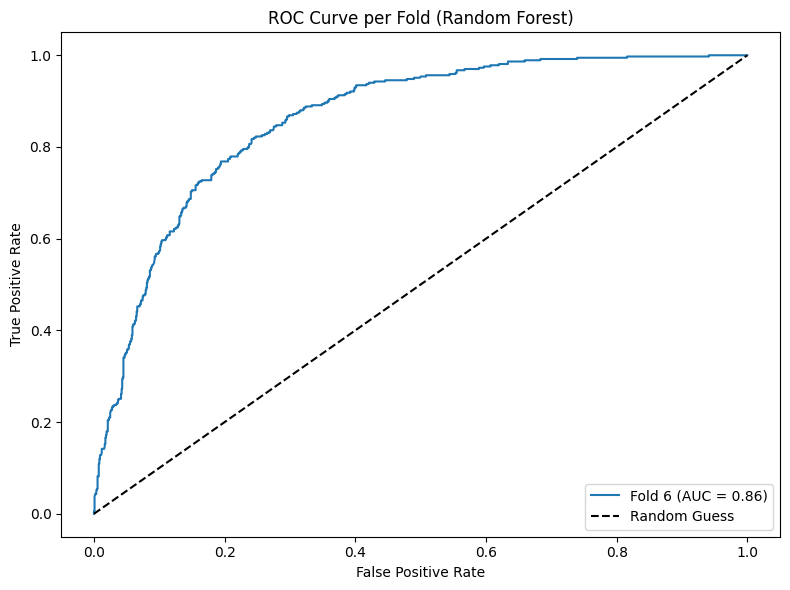


Average AUC across folds (Random Forest): 0.8611


In [ ]:
auc_scores_rf = []
y_proba_rf = rf_model.predict_proba(X_test_fold)[:, 1]
auc_rf = roc_auc_score(y_test_fold, y_proba_rf)
auc_scores_rf.append(auc_rf)
fpr, tpr, _ = roc_curve(y_test_fold, y_proba_rf)

#Gráfica
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Fold (Random Forest)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f"\nAverage AUC across folds (Random Forest): {np.mean(auc_scores_rf):.4f}")

## Análisis Dirigido

## Duración de contrato x Cancelación

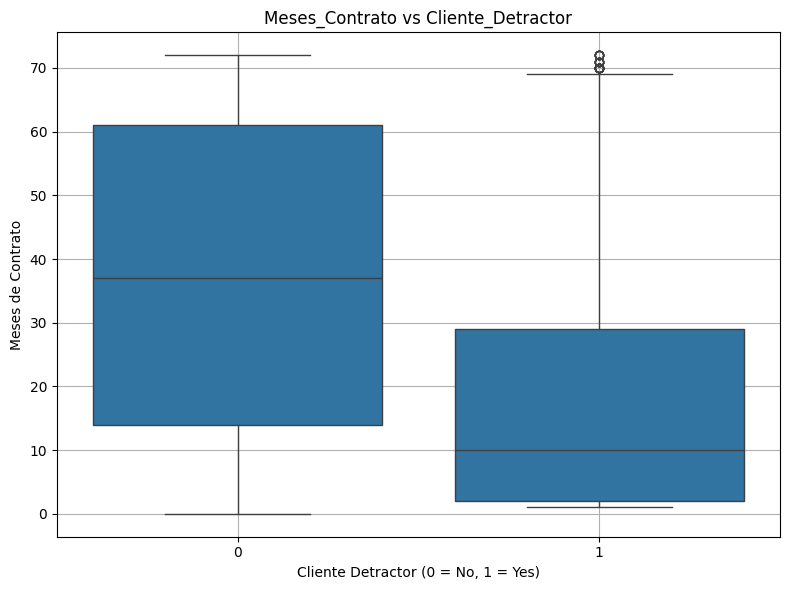

In [ ]:

plt.figure(figsize=(8, 6))
sns.boxplot(data=Df_final, x='Cliente_Detractor', y='Meses_Contrato')
plt.title('Meses_Contrato vs Cliente_Detractor')
plt.xlabel('Cliente Detractor (0 = No, 1 = Yes)')
plt.ylabel('Meses de Contrato')
plt.grid(True)
plt.tight_layout()
plt.show()

## Total Facturado x Cancelación

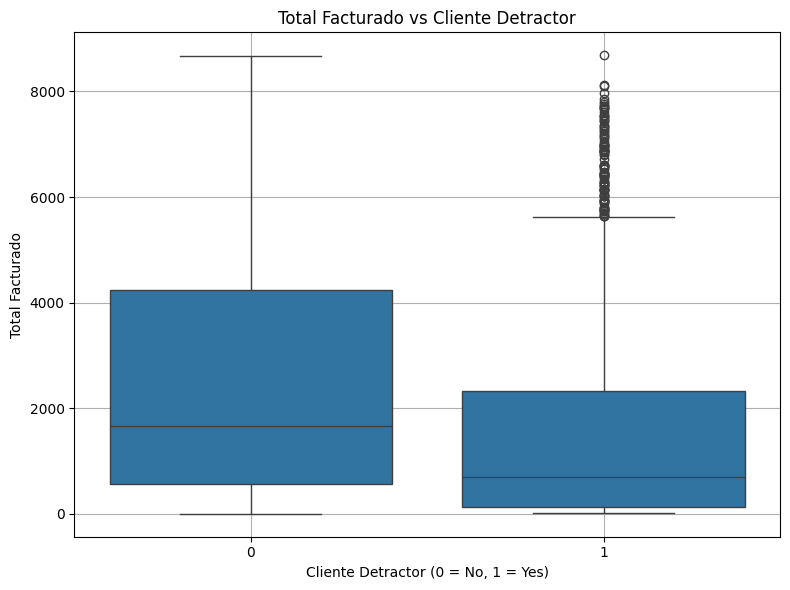

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=Df_final, x='Cliente_Detractor', y='Total_Facturado')
plt.title('Total Facturado vs Cliente Detractor')
plt.xlabel('Cliente Detractor (0 = No, 1 = Yes)')
plt.ylabel('Total Facturado')
plt.grid(True)
plt.tight_layout()
plt.show()

CONCLUSIONES:
Análisis del Churn en Telecomunicaciones

Uno de los retos más importantes para las compañías de telecomunicaciones es lograr que los clientes permanezcan en la empresa a lo largo del tiempo. La competencia en el mercado, la gran variedad de planes y servicios disponibles, y los cambios frecuentes en las expectativas de los usuarios hacen que la cancelación del servicio (churn) se convierta en una amenaza constante para la rentabilidad.

Con esta preocupación como punto de partida, se llevó a cabo un estudio dentro del proyecto Telecom X – Parte 2, en el que se aplicaron técnicas de machine learning con el fin de anticipar qué clientes tienen mayor probabilidad de abandonar el servicio. La idea fue utilizar la información histórica de la compañía para identificar patrones y así generar un modelo que no solo explique el churn, sino que permita actuar de forma preventiva.

Durante la experimentación se entrenaron distintos algoritmos de clasificación. Aunque se probaron enfoques como la Regresión Logística y KNN, el que ofreció mejores resultados fue el Random Forest. Este método demostró un equilibrio notable entre rendimiento y estabilidad: logró detectar correctamente al 83 % de los clientes que efectivamente cancelaron, lo cual lo convierte en un aliado sólido para la gestión temprana del riesgo.

El análisis también permitió descubrir cuáles son los factores más estrechamente relacionados con la decisión de cancelar. Entre ellos destacan:

Los contratos de tipo mensual, que facilitan la salida rápida del servicio.

El uso de fibra óptica, donde los clientes parecen abandonar con mayor frecuencia, posiblemente por una diferencia entre lo prometido y lo experimentado.

La baja antigüedad, que convierte a los usuarios recién incorporados en un segmento inestable.

El pago mediante electronic check, asociado a un mayor nivel de cancelación en comparación con métodos digitales automáticos.

Estos hallazgos sugieren que existen segmentos de clientes especialmente sensibles, lo cual abre la puerta a diseñar intervenciones dirigidas. Algunas acciones recomendadas incluyen: incentivar la migración de planes mensuales a contratos más largos con beneficios adicionales; prestar un acompañamiento cercano a los usuarios de fibra óptica, resolviendo con rapidez las fallas reportadas; implementar un programa de bienvenida para quienes apenas se afilian, con soporte intensivo durante los primeros meses; y finalmente, promover métodos de pago automáticos mediante incentivos que hagan más atractiva la transición.

Más allá de las acciones concretas, lo más valioso del ejercicio fue comprobar cómo la analítica de datos y el aprendizaje automático pueden convertirse en herramientas estratégicas para enfrentar el problema del churn. No solo se obtiene una radiografía de los factores que inciden en la cancelación, sino que también se gana la capacidad de anticipar comportamientos y de diseñar campañas personalizadas para cada perfil de riesgo.

En conclusión, el trabajo desarrollado refuerza la idea de que la retención de clientes no depende únicamente de promociones o campañas de marketing, sino de una gestión inteligente basada en datos. Con el uso de modelos predictivos como el Random Forest y la aplicación de estrategias derivadas de la evidencia, la empresa puede reducir su tasa de cancelación, mejorar la experiencia de los usuarios y fortalecer su posición en un mercado altamente competitivo.

